# Convolution for CIFAR-10

Image classifier based on CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
Based on following examples:
 * Model definition: https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/index.html
 * Layers visualisation: https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist_v1.ipynb

In [1]:
%matplotlib inline

import numpy as np
import pylab
from PIL import Image
from keras.datasets import cifar10
from keras.models import Model
import keras.layers
from keras.utils import np_utils
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten, Activation

Using TensorFlow backend.


In [2]:
batch_size = 32 # 32
num_epoch = 5 # 200
kernel_size = 3
pool_size = 2

conv_depth_1 = 16
conv_depth_2 = 64
drop_prob_1 = 0.25
drop_prob_2 = 0.5
hidden_size = 512

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # fetch CIFAR-10 data

In [4]:
num_train, height, width, depth = X_train.shape
num_test = X_train.shape[0]
num_classes = np.unique(y_train).shape[0]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= np.max(X_train)
X_test /= np.max(X_test)

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

Model consist of: 4 Conbolution with Max pooling and Dropout and softmax after hidden layer

In [ ]:
input = Input(shape = (height, width, depth))
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(input)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1) 

conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size = (pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2) 

flat = Flatten()(drop_2)
hidden = Dense(hidden_size)(flat)
drop_3 = Dropout(drop_prob_2)(hidden) 
output = Dense(num_classes, activation='softmax')(drop_3)

model = Model(inputs = input, outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, Y_train, batch_size = batch_size, epochs = num_epoch, verbose = 1, validation_split = 0.1)
model.evaluate(X_test, Y_test, verbose = 1)

### Visualizations of layers

In [182]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 64)        9280      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 64)        36928     
__________

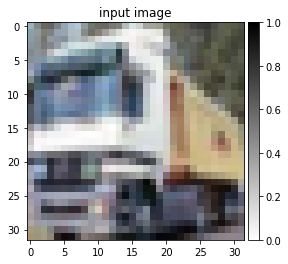

In [178]:
from keras import backend as K
import pylab as pl
import matplotlib.cm as cm

# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
# Training sample to visualize
i = 1

# Visualize the first layer of convolutions on an input image
X = X_train[i:i+1]

pl.figure()
pl.title('input image')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

(16, 32, 32)


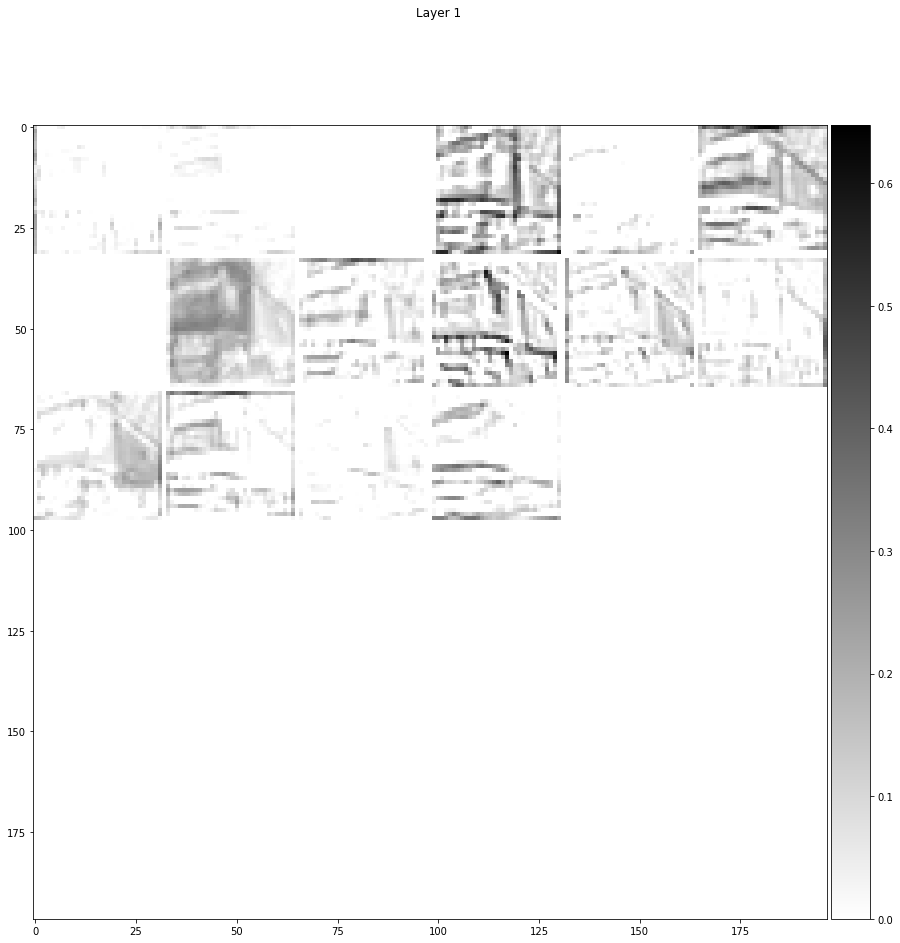

In [197]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]


    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

layer_index = 1

# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs
layer = model.layers[layer_index]

_convout1_f = K.function(inputs, [layer.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])


C1 = convout1_f(X)
C1 = np.squeeze(C1)

# Last dimension is depth(filters)
# Move it to begining for simplification of mosaic logic
C1 = np.einsum('ijk->kij', C1)
print (C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('Layer ' + str(layer_index))
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)

In [2]:
import tensorflow as tf
print ("VERSION" + str(tf.Session(config=tf.ConfigProto(log_device_placement=True))))


VERSION<tensorflow.python.client.session.Session object at 0x118749eb8>
